#### This program is an integral part of summative assignment for Applied Artificial Intelligence-dated 25 Jun 2023
#### Files:  Summative_AAI.pdf, SVM_CO2.ipynb, energy.csv, pseudo_data.csv

# Imports

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import ttest_rel

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from sklearn.model_selection import TimeSeriesSplit
sns.set_theme(style='whitegrid')

%matplotlib inline

## Constants

In [2]:
# File names, feature list, mutation rate
DATA_FILE = 'energy.csv'
PSEUDO_FILE = 'pseudo_data.csv'
# Coal, Oil, Hydroelectric, Wind&wave, solar, landfill gas, Sewage gas, biogas, poultry litter, charcoal,
# Straw, Waste, Wood, Bioethanol&diesel, Biomass
FEATURE_LIST = ['COAL','OIL','GAS','HYDRO','WINWAV','SOL','LGAS','SGAS','BGAS','POLT','CHAC',
                'STRW','WAST','WD','BIOED','BMAS']
SINGLE = 1
DOUBLE = 2

# Read and Explore Data

In [3]:
# read the file to generate a new core dataframe
data_all = pd.read_csv(DATA_FILE)
data_all.shape

(31, 18)

In [4]:
# check any empty values
pd.isnull(data_all).any()

YR        False
CO2       False
COAL      False
OIL       False
GAS       False
HYDRO     False
WINWAV    False
SOL       False
STRW      False
LGAS      False
SGAS      False
BGAS      False
POLT      False
CHAC      False
WAST      False
WD        False
BIOED     False
BMAS      False
dtype: bool

In [5]:
# Set year as an index of the core dataframe, read head of the dataframe to check 
data_all.set_index('YR', inplace=True)
data_all.head()

,CO2,COAL,OIL,GAS,HYDRO,WINWAV,SOL,STRW,LGAS,SGAS,BGAS,POLT,CHAC,WAST,WD,BIOED,BMAS
YR,,,,,,,,,,,,,,,,,
1990,10.521595,93.984365,81.007574,42.221283,0.448,0.001,0.0,0.007,0.080,0.138,0.0,0.000,0.039,0.183,0.687,0.0,0.065
1991,10.624450,95.576325,82.299265,45.859532,0.398,0.001,0.0,0.007,0.105,0.151,0.0,0.000,0.036,0.185,0.687,0.0,0.065
1992,10.326096,90.820876,82.081540,46.717678,0.467,0.003,0.0,0.007,0.155,0.151,0.0,0.016,0.033,0.210,0.736,0.0,0.065
1993,10.054433,82.236229,86.780843,54.481028,0.370,0.019,0.0,0.007,0.162,0.158,0.0,0.043,0.034,0.268,0.736,0.0,0.065
1994,9.933511,77.675184,85.769949,57.828432,0.438,0.030,0.0,0.007,0.188,0.170,0.0,0.101,0.034,0.385,1.108,0.0,0.065


In [6]:
# some information about data - mean, max standatd deviation
data_all.describe()

,CO2,COAL,OIL,GAS,HYDRO,WINWAV,SOL,STRW,LGAS,SGAS,BGAS,POLT,CHAC,WAST,WD,BIOED,BMAS
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,8.545309,57.680892,81.071778,73.787729,0.431323,1.299968,0.209581,0.092194,1.023968,0.247387,0.200161,0.153613,0.048226,1.118419,1.844097,0.522161,0.594129
std,1.696815,22.598760,5.877169,14.053414,0.067324,1.867693,0.392818,0.098076,0.608756,0.095966,0.353263,0.067326,0.020654,0.896538,1.545942,0.609276,0.695856
min,4.865281,10.134796,63.974369,42.221283,0.278000,0.001000,0.000000,0.007000,0.080000,0.138000,0.000000,0.000000,0.031000,0.183000,0.687000,0.000000,0.029000
25%,7.424812,50.161264,78.261884,66.080592,0.399000,0.065000,0.000000,0.007000,0.359500,0.172000,0.000000,0.106500,0.034500,0.549000,0.772000,0.000000,0.065000
50%,9.439250,62.707209,82.081540,75.310365,0.438000,0.250000,0.001000,0.076000,1.202000,0.193000,0.005000,0.176000,0.038000,0.816000,1.108000,0.075000,0.386000
75%,9.751024,66.875969,85.537419,85.797186,0.463500,2.074500,0.144500,0.098500,1.555000,0.319000,0.214500,0.207500,0.051500,1.221000,2.164500,1.038500,0.665500
max,10.624450,95.576325,89.014296,90.736081,0.580000,6.481000,1.131000,0.338000,1.758000,0.440000,1.021000,0.227000,0.107000,3.367000,5.478000,1.762000,2.469000


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.06 µs


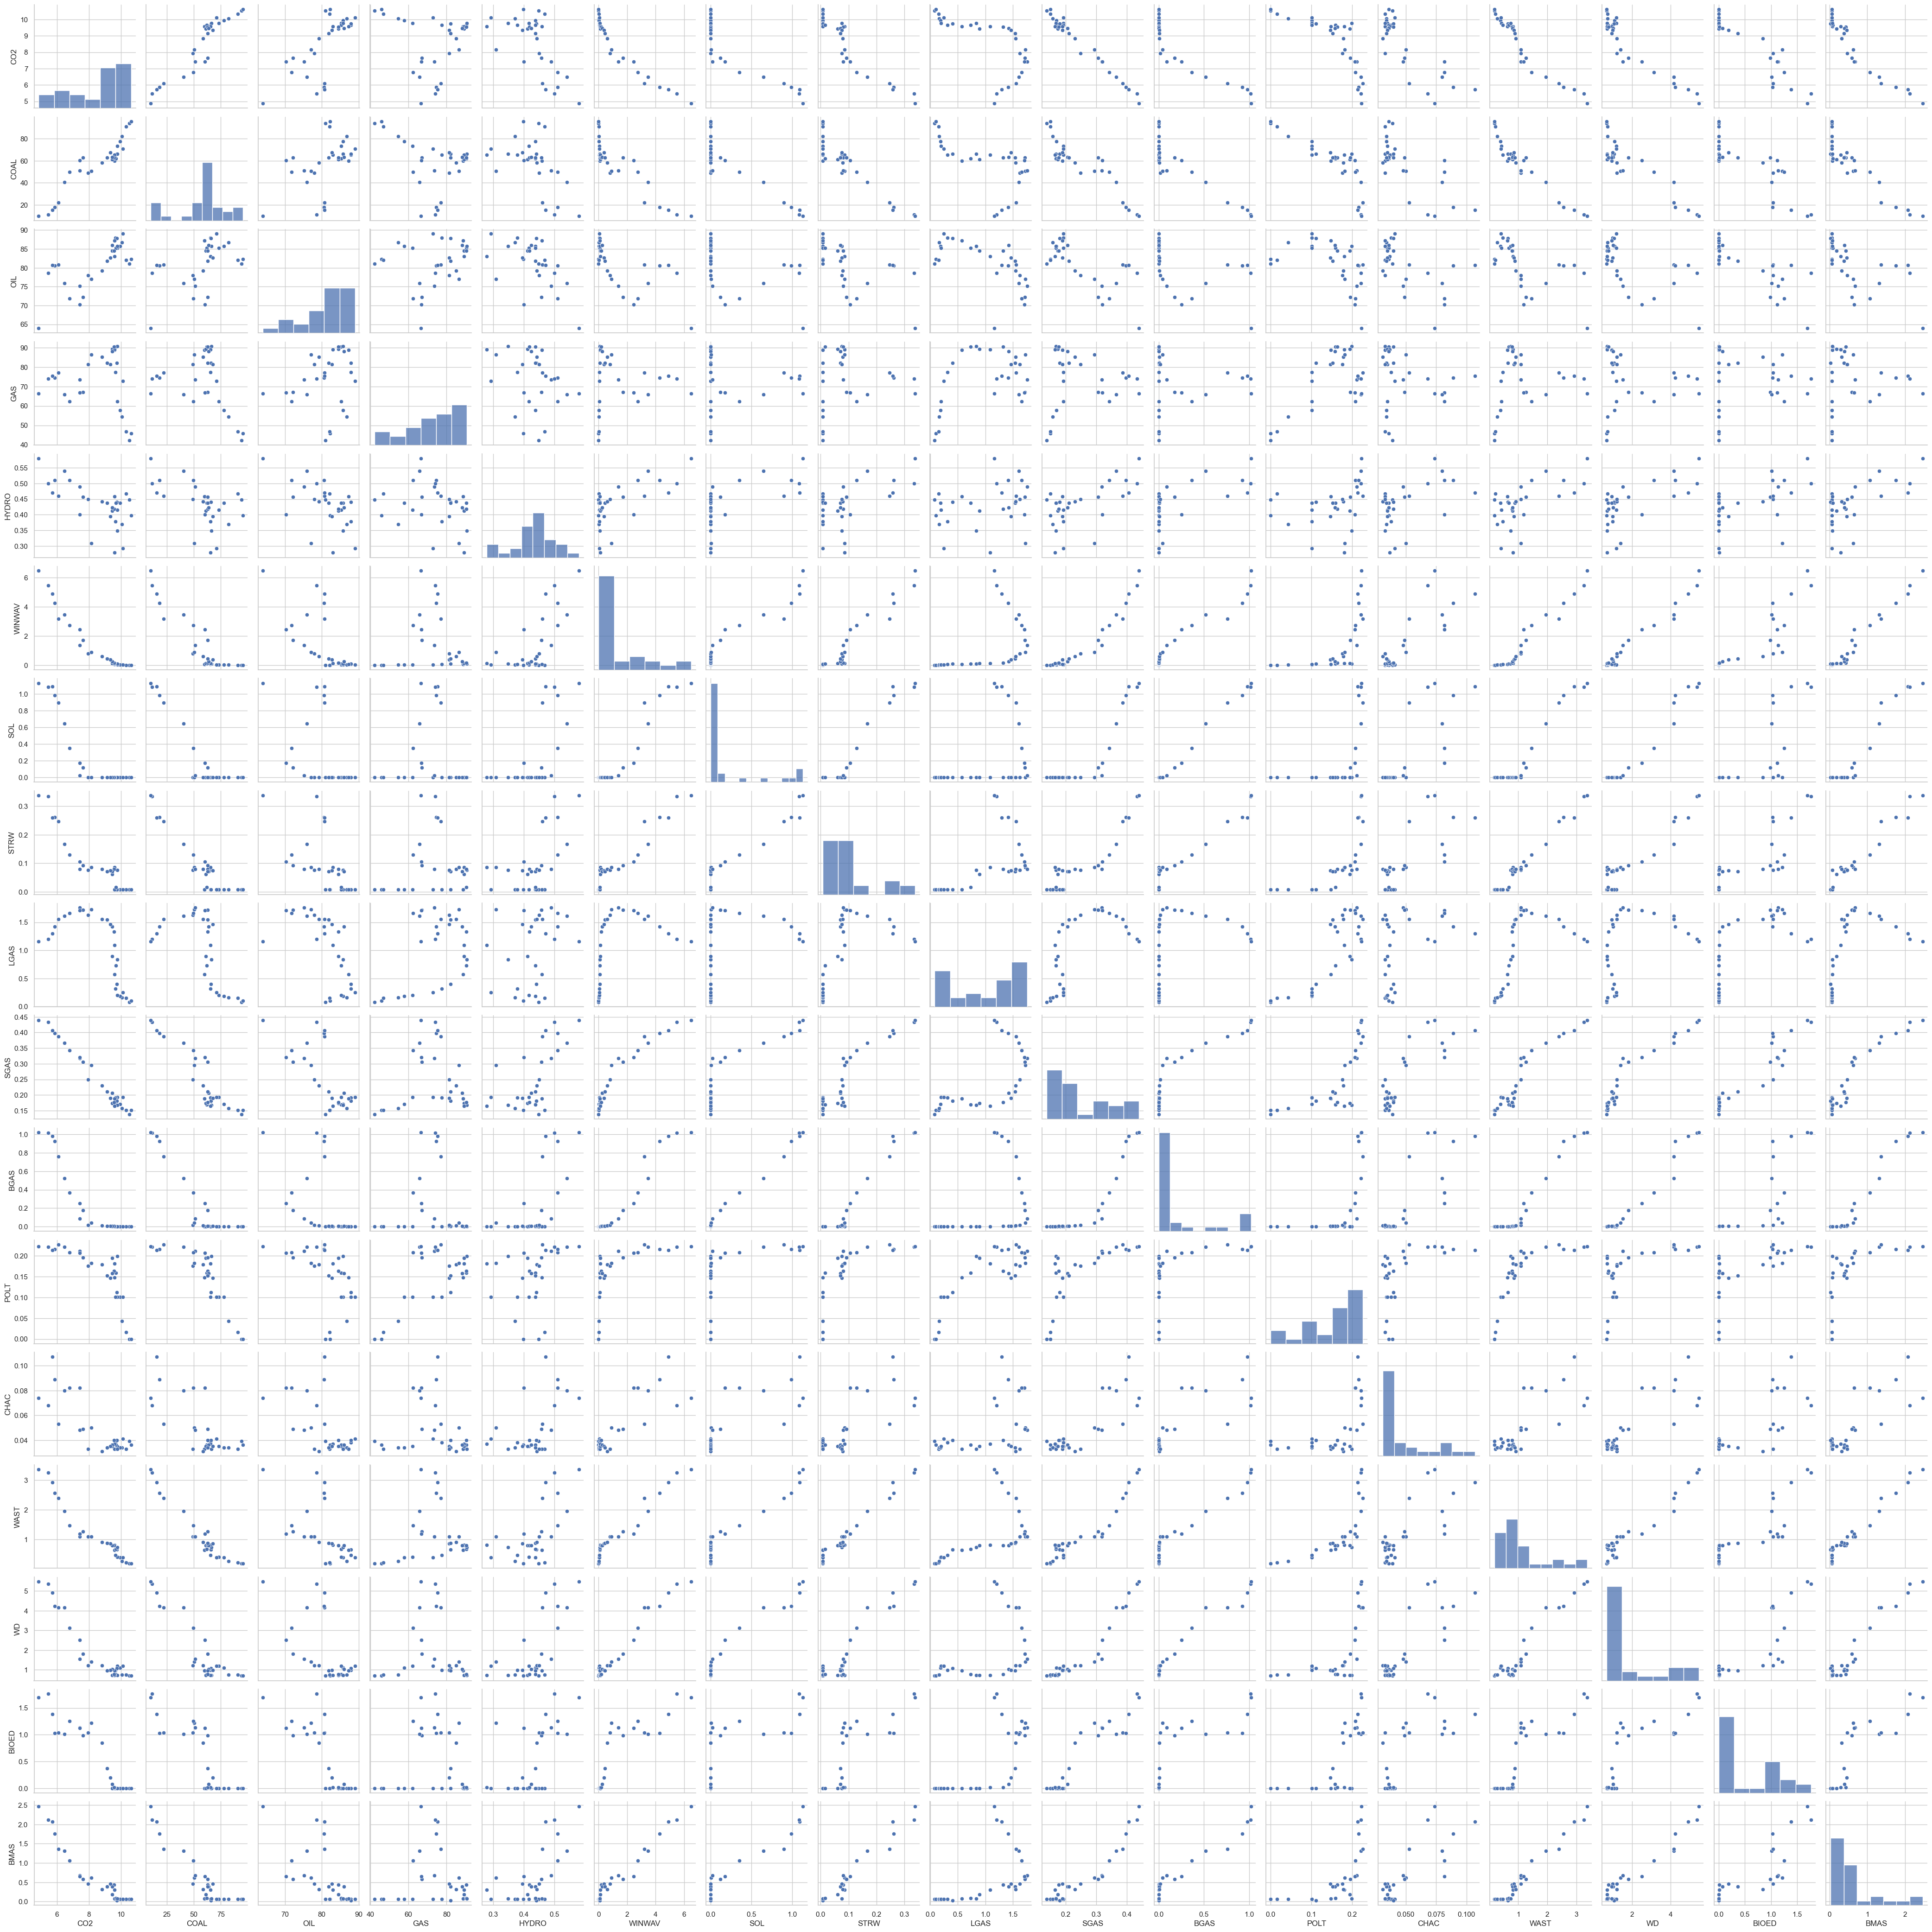

In [7]:
%time
# pairplot for all variables  
sns.pairplot(data_all)

In [8]:
# skewness of data
data_all.skew()

CO2      -0.790365
COAL     -0.690306
OIL      -1.069296
GAS      -0.716329
HYDRO    -0.349197
WINWAV    1.501444
SOL       1.646308
STRW      1.362983
LGAS     -0.386607
SGAS      0.789277
BGAS      1.624182
POLT     -1.074998
CHAC      1.455411
WAST      1.376845
WD        1.389244
BIOED     0.589928
BMAS      1.473449
dtype: float64

### Visualise Trends: CO2 per capita

In [9]:
# display the label's trend for 30 years  
def display_CO2_trend(df=data_all):
#     plt.style.use('seaborn-v0_8-bright')
    graph = sns.relplot(data = df,
                      x='YR', y='CO2',
                      kind='line', linewidth=3,
                      legend=False)

    plt.title('Fossil Fuel CO2 Emission per Capita: 1990~2020')
    plt.xlim([1990, 2020])
    plt.xlabel('Year')
    plt.ylabel('CO2 emission per capita (metric tons)')

    plt.show()

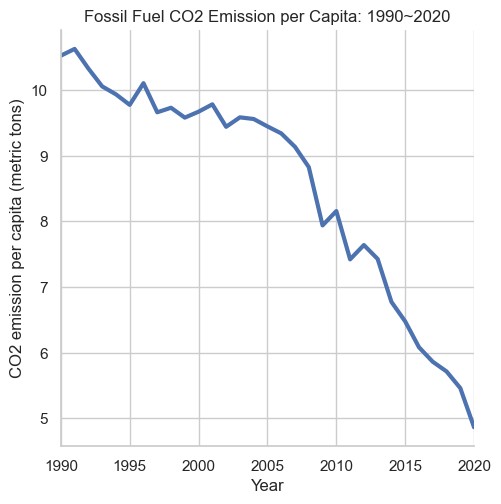

In [10]:
display_CO2_trend()

### Visualise Trends: Fuel Consumption

In [11]:
# Trend of all features for 30 years
def display_fuel_trend(df_in=data_all):
    df = df_in
    # generage new dataframe for a trend analysis of 5 major fuel source consumption
    yrs = np.arange(1990, 2021, 1, dtype=int)
    
    # add new column with the sum of renewabl/waste sources 
    df['renew'] = (df['HYDRO'].values + df['WINWAV'].values + df['SOL'].values + df['BGAS'].values 
                   + df['SGAS'].values +df['LGAS'].values + df['STRW'].values + df['WAST'].values 
                   + df['WD'].values + df['BIOED'].values + df['BMAS'].values + df['POLT'].values
                   + df['CHAC'].values)
    graph_data = pd.DataFrame({'Coal': df['COAL'],'Oil':df['OIL'], 'Gas':df['GAS'], 
                               'Renewable/Waste': df['renew']}, index=yrs)
   
    plt.figure(figsize = (10, 6), dpi=170)
    sns.set_theme(style='whitegrid')
    plt.title('UK Energy Consumption by source 1990~2020 (Excluding Nuclear energy)', fontsize=17)
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Energy Consumption (Mtons)', fontsize=15)
    plt.xlim([1990, 2020])
    plt.ylim([0, 98])
    sns.lineplot(data=graph_data, palette='tab10', linewidth=3)
    
    # delete the renewable column for other cells
    del data_all['renew']

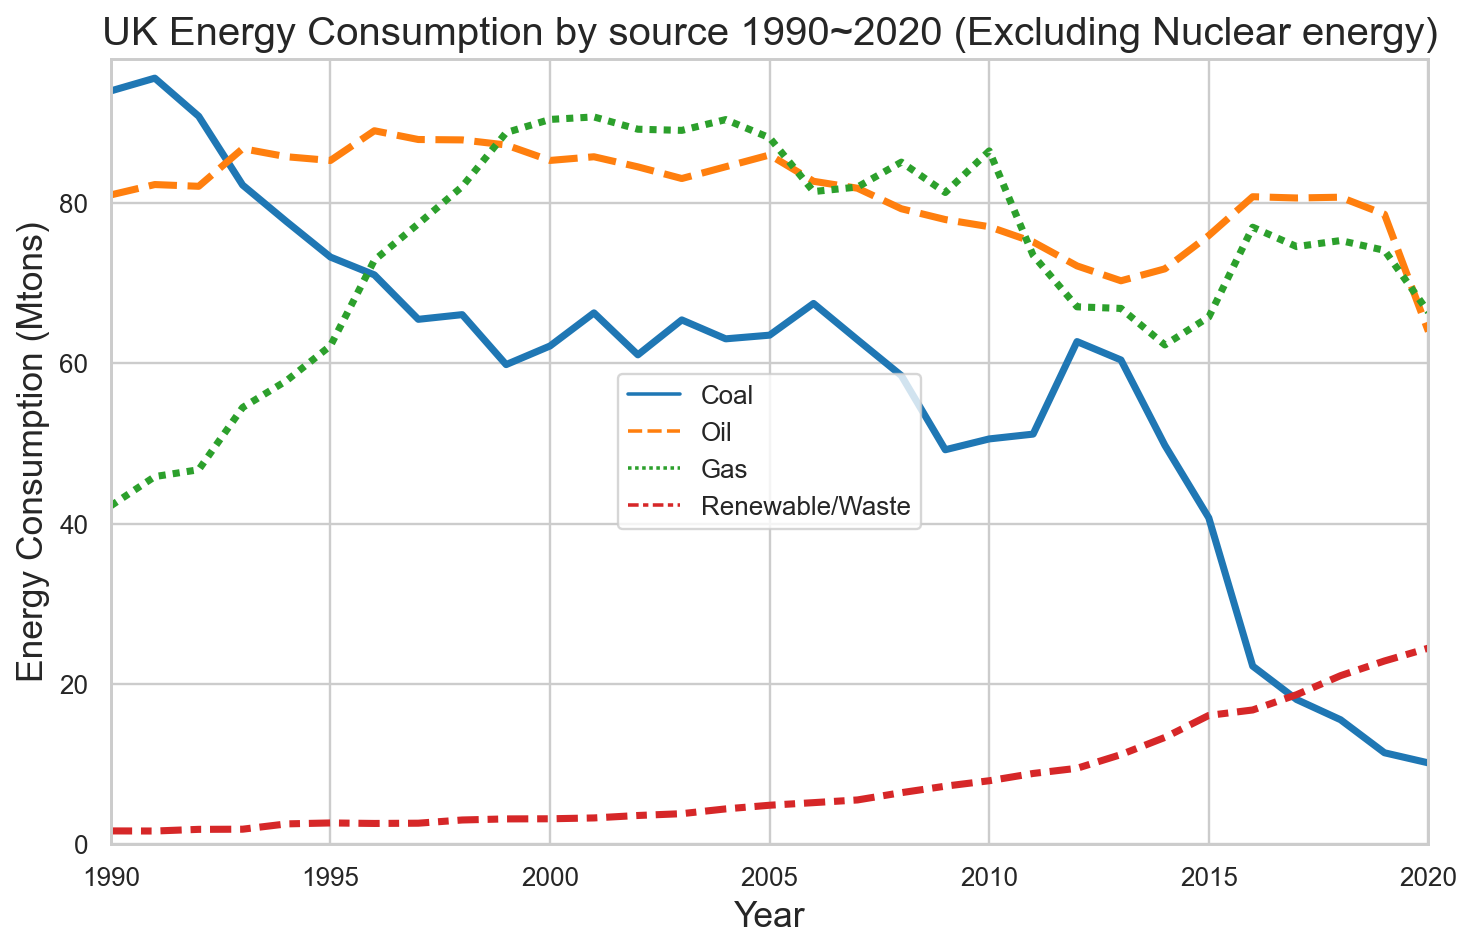

In [12]:
display_fuel_trend()

### Visualise Trends: Renewable and Waste Energy

In [13]:
# visualise detailed renewable and waste energy trend for last 30 years
def display_renewables_trend():
    
    df_in=data_all
    plt.figure(figsize = (10, 6))
    yr = np.arange(1990, 2021, 1, dtype=int)
    idx = np.arange(0,31,1, dtype=int)
    plt.style.use('default')
    
    # new dataframe for the plot - values of each major renewable/waste sources consumptions
    plot = pd.DataFrame({'Wind/Wave':df_in.WINWAV.values, 'Solar':df_in.SOL.values, 
                         'Landfill Gas': df_in.LGAS.values,
                        'Waste':df_in.WAST.values, 'Wood':df_in.WD.values,
                        'Sewage Gas': df_in.SGAS.values,
                        'Biomass':df_in.BMAS.values,'Hydroelectric':df_in.HYDRO.values,
                        'Bioethanol/Biodiesel': df_in.BIOED.values,
                        'Biogas':df_in.BGAS.values, 'Year':yr }, index=idx)

    fig, ax = plt.subplots()
    ax.stackplot(plot['Year'].values, plot.drop('Year', axis=1).T, labels=plot.columns, alpha=0.9)
    ax.legend(loc='upper left')
    ax.set_title('Renewable and Waste Energy Consumption')
    ax.set_xlabel('Year')
    ax.set_ylabel('Million metric tons')
    plt.xlim([1990,2020])
    plt.show()

<Figure size 1000x600 with 0 Axes>

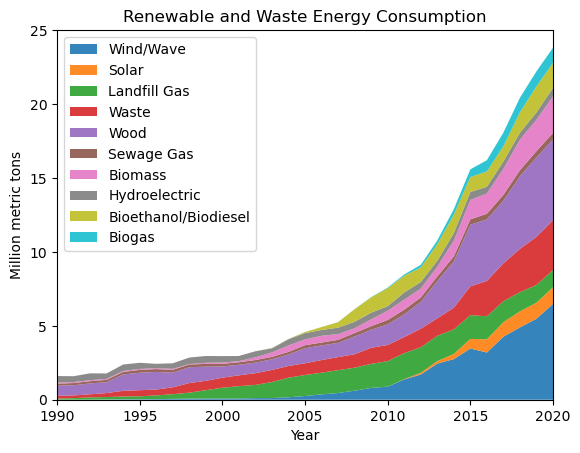

In [14]:
display_renewables_trend()

### Pearson Correlation
### $ \rho _{XY} = corr(X,Y)$
### $ -1.0 \leq \rho _{XY} \leq +1.0 $

In [15]:
# Fine correlations between variables
def display_corr_heat_map(df=data_all):
    # generate correlation mask
    corr_data = df.corr()
    mask_feat = np.zeros_like(corr_data)
    triangles = np.triu_indices_from(mask_feat)
    mask_feat[triangles] = True
    
    # heat map config
    plt.figure(figsize=[16,10])
    sns.heatmap(corr_data, mask=mask_feat, annot=True, annot_kws={"size":14})
    sns.set_style('white')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


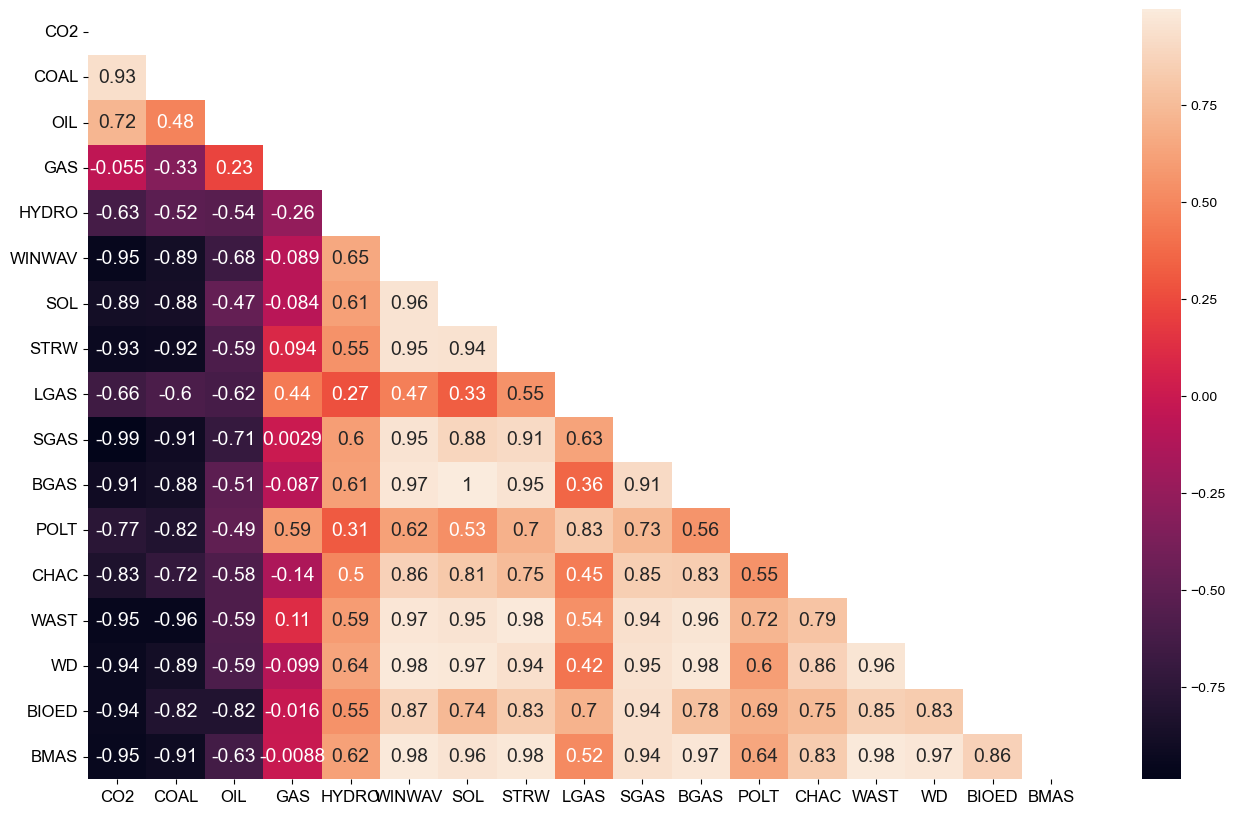

In [16]:
display_corr_heat_map()

### Feature Relationship: Ordinary Least Squares Analysis

#### Renewables and CO2 per capita

## $\\{R^2}= 1 - \frac{\sum_{i=1}^{T} \small( y\; - \;\hat{y} \small)^2 }{\sum_{i=1}^{T} \small( y\; - \;\bar{y} \small)^2 } $  
#### *$y$ is the actual and $\hat{y}$ is predicted $\bar{y}$ is mean value of y

In [17]:
# Display the relationship between CO2 and energy sources
def display_energy_co2_regression(df, fuel:str):
    plt.figure(figsize=(8, 4))
    #plt.style.use('fivethirtyeight')
    
    FUEL = fuel.upper()
    plot_data = df
    X = plot_data[[FUEL]] # X
    y= plot_data[['CO2']] # y
    
    # Pearson correlations 
    corr = plot_data[FUEL].corr(plot_data['CO2'])
    #regression - OLS
    regr = LinearRegression()
    regr.fit(X.values, y.values)
    pred = regr.predict(X.values)

    plt.title(f'{fuel} Energy vs CO2 Emission: corr: {round(corr, 3)}', fontsize=15)
    plt.xlabel(f'Energy by {fuel} Sources (Million metric tons)')
    plt.ylabel('CO2 per capita (metric tons)')
    plt.scatter(X, y, alpha=0.7, c='limegreen',s=80)
    plt.plot(X, pred, color='navy', linewidth=3)
    plt.show()
    
    # Find coefficien, intercept for trend, r-square, BIC to evaluate the regression
    coef = regr.coef_[0][0]
    intercept = regr.intercept_[0]
    r_square = regr.score(X.values, y.values)
    print(f'Coefficient : {round(coef, 3)}' )
    print(f'Intercept: {round(intercept, 3)}') 
    print(f'R square: {round(r_square, 3)}')
    
    # evaluation metrics - statsmodel 
    x_incl_const = sm.add_constant(X)
    model = sm.OLS(y, x_incl_const)
    result = model.fit()
    print(f'p-values : {round(result.pvalues, 3)}')
    print(f'Baysian Information Criterion : {round(result.bic, 3)}')
    


<<<<<< Wind and Wave Energy >>>>>>


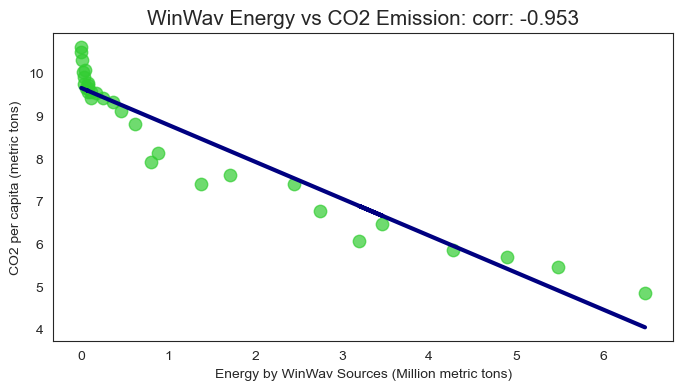

Coefficient : -0.866
Intercept: 9.671
R square: 0.909
p-values : const     0.0
WINWAV    0.0
dtype: float64
Baysian Information Criterion : 52.263

<<<<<< Solar Energy >>>>>>


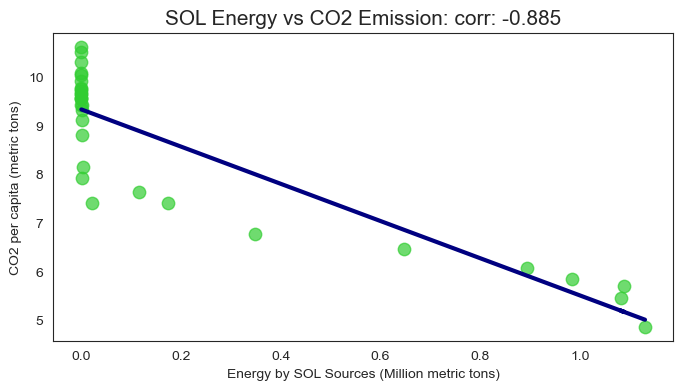

Coefficient : -3.824
Intercept: 9.347
R square: 0.784
p-values : const    0.0
SOL      0.0
dtype: float64
Baysian Information Criterion : 79.149

<<<<<< Biomass Energy >>>>>>


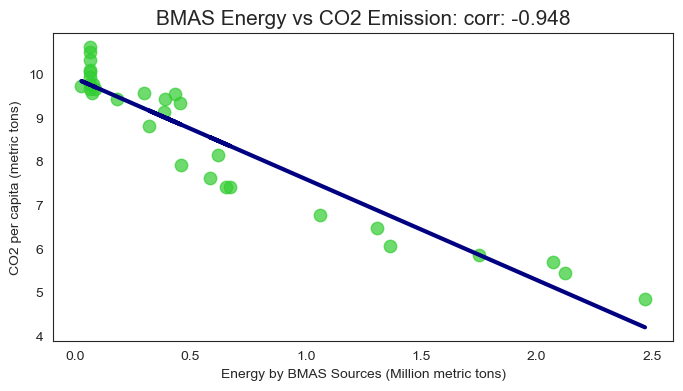

Coefficient : -2.313
Intercept: 9.919
R square: 0.899
p-values : const    0.0
BMAS     0.0
dtype: float64
Baysian Information Criterion : 55.383


In [18]:
#inear regression between CO2 emission and some renewable sources

print("\n<<<<<< Wind and Wave Energy >>>>>>")
display_energy_co2_regression(df=data_all,fuel='WinWav')
print("\n<<<<<< Solar Energy >>>>>>")
display_energy_co2_regression(df=data_all,fuel='SOL')
print("\n<<<<<< Biomass Energy >>>>>>")
display_energy_co2_regression(df=data_all,fuel='BMAS')



<<<<<< Coal Energy >>>>>>


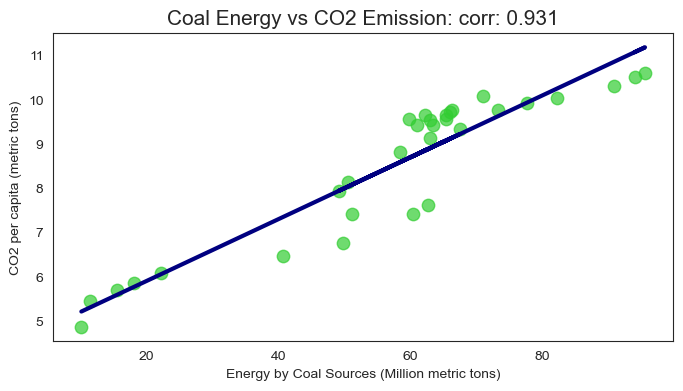

Coefficient : 0.07
Intercept: 4.514
R square: 0.867
p-values : const    0.0
COAL     0.0
dtype: float64
Baysian Information Criterion : 64.166

<<<<<< Oil Energy >>>>>>


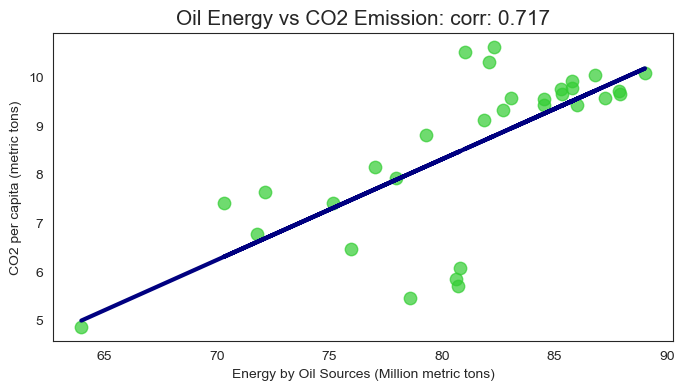

Coefficient : 0.207
Intercept: -8.247
R square: 0.515
p-values : const    0.011
OIL      0.000
dtype: float64
Baysian Information Criterion : 104.195

<<<<<< Gas Energy >>>>>>


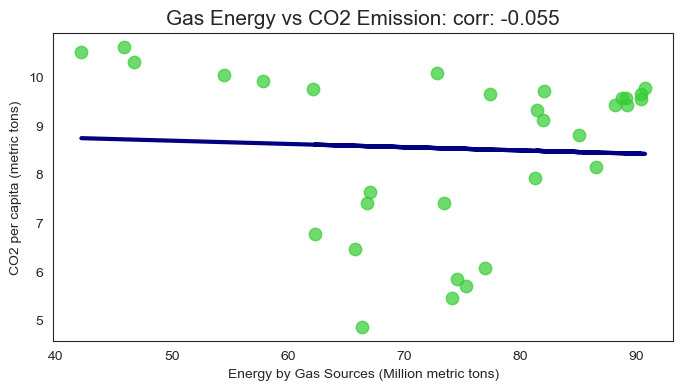

Coefficient : -0.007
Intercept: 9.038
R square: 0.003
p-values : const    0.000
GAS      0.768
dtype: float64
Baysian Information Criterion : 126.514


In [19]:
# linear regression between CO2 emission and fossil fuel sources
print("\n<<<<<< Coal Energy >>>>>>")
display_energy_co2_regression(df=data_all, fuel='Coal')
print("\n<<<<<< Oil Energy >>>>>>")
display_energy_co2_regression(df=data_all, fuel='Oil')
print("\n<<<<<< Gas Energy >>>>>>")
display_energy_co2_regression(df=data_all, fuel='Gas')

# Model: Support Vector Regressor

## Loss Functions
### Mean Absolute Error (MAE) : $\;\;\frac{1}{T}{\sum_{i=1}^{T}|\hat{y} - y |}$
### Mean Absolute Percentage Error (MAPE) : $\;\;\frac {100\%}{T}\sum_{i=1}^{T}|\frac{y\;- \;\hat{y}}{y}| $
###  Root Mean Squared Error (RMSE) : $\;\;\sqrt\frac{1}{T} \sqrt{{\sum_{i=1}^{T} \big( y\; - \;\hat{y} \big)^2 }}$
#### *$y$ is the actual and $\hat{y}$ is predicted

In [20]:
# Core function - train and test the SVM model using the given set of features
def train_test_model(df_in= data_all, feature_list:list=FEATURE_LIST, graph=False):
    """
    function builds poly kernel SVM using selected features
    
    df_in: the core dataframe (pandas dataframe)
    feature_list: all features or selected subset of features in 1-d array with strings
    graph: boolean, if true the mean average error during training and testing will be shown in two matplotlib plots    
    returns a tuple contaiin:
      1. a new dataframe contains the feature size, average MAE, MAPE, RMSE from testing sessions and
      2. the difference between testing MAE values from 2 sessions to be used for penalty cost calculation on the GA
    """
    
    # input and outcome values
    X_0 = df_in[feature_list]
    co2 = df_in['CO2']
    
    # normalise
    scaler = PowerTransformer()
    X = X_0[:]
    X[feature_list] = scaler.fit_transform(X[feature_list])
    y = np.log(co2)

    # time-series split - more split makes model unstable due to decreased data points
    tss = TimeSeriesSplit(n_splits=2)
    
    # Support Vector Regressor
    model = SVR(kernel='poly', C=1.5, degree=3, gamma='auto', epsilon=1e-2)

    # empty list for performance evaluation
    mae_list= []
    mape_list = []
    rmse_list = []
    

    # apply time series split and fit the model
    for train_index, test_index in tss.split(df_in):
        
        x_train, x_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
#         print(test_index)
        # fit the model and make predictions         
        model.fit(x_train, y_train)
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        
        # list of errors between actual and testing predictions 
        mae_ea = mean_absolute_error(y_test, y_test_pred)
        mape_ea = mean_absolute_percentage_error(y_test, y_test_pred)
        rmse_ea= mean_squared_error(y_test, y_test_pred)
        mae_list.append(mae_ea)
        mape_list.append(mape_ea)
        rmse_list.append(rmse_ea)
        
    # Find testing MAE diff between testings - check overfitting
    error_diff = max(mae_list) - min(mae_list)
    
    if graph: # represent the train/test as graph
        print(f'============= Features : {feature_list} =============')
        # Display error comparion during train/test
        plt.style.use('default')    
        plt.figure(figsize=[10, 3])
        plt.subplot(1, 2, 1)
        plt.plot(train_index+1990, np.exp(y_train), color = 'limegreen', linewidth=3.5, alpha = 0.8)
        plt.plot(train_index+1990, np.exp(y_train_pred), color = 'navy', linewidth=2)

        plt.legend(['Actual','Predicted'])
        plt.xlabel('Year')
        plt.ylabel('CO2 per capita')
        plt.title("Training data prediction")

        plt.subplot(1, 2, 2)
        plt.plot(test_index+1990,np.exp(y_test), color = 'limegreen', linewidth=3.5, alpha = 0.8)
        plt.plot(test_index+1990, np.exp(y_test_pred), color = 'navy', linewidth=2)

        plt.legend(['Actual','Predicted'])
        plt.xlabel('Year')
        plt.ylabel('CO2 per capita')
        plt.title("Testing data prediction")
        plt.show()    

    # Average errors between actual and testing predictions 
    items = len(feature_list) 
    mae = np.mean(mae_list)
    mape = np.mean(mape_list)
    rmse = np.mean(rmse_list)

    # Make a dataframe 
    df = pd.DataFrame({'MAE': np.round(mae, 3), 'MAPE': np.round(mape,3),
                       'RMSE': np.round(rmse, 3)}, index=[f'{items} Features'])
    return df, error_diff
   

## Model with All Features

============= Features : ['COAL', 'OIL', 'GAS', 'HYDRO', 'WINWAV', 'SOL', 'LGAS', 'SGAS', 'BGAS', 'POLT', 'CHAC', 'STRW', 'WAST', 'WD', 'BIOED', 'BMAS'] =============


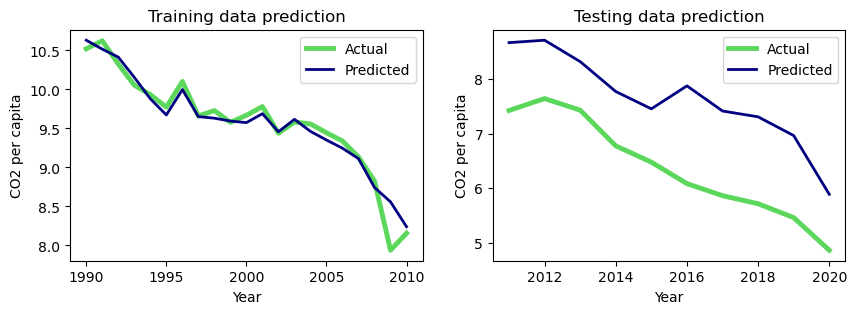

(               MAE   MAPE   RMSE
 16 Features  0.124  0.066  0.022,
 0.12210004228619603)

In [21]:
train_test_model(graph=True, feature_list=FEATURE_LIST)

# Feature Engineering
### Genetic algorithm

In [22]:
def initialize_population(feat_size:int):
    """ 
    randomly generate initial population -features
    feat_size : number of features in a subset, must be between 2 n 14
    returns selected list of subsets contains features 
    """
    if feat_size < 2 or feat_size > 14:
        print('incorrect feature size')
        return
    
    feature_names = FEATURE_LIST
    selected = []
    # randomly selecting features 
    for i in range(feat_size):
        selected = random.sample(feature_names, feat_size)

    return selected
    

def compare_fitness(df_in, populations:list):
    """
    Objective function to compare 2 subsets
    df_in :  the core dataframe holds all data
    populations: 2*lists of combinations of selected features 
    returns a subset with lower penalty score 
    """
    data = df_in
    # copy of each combination
    copy = populations[:]
    result= []
    # initial value
    min_pen = 100
    
    # compare MAE from all populations to find a combination with lower penalty score
    penalty_score_list = []
    best_pop=[]
    for i in range(len(copy)):
        penalty_score = score_fitness(data, copy[i])
        penalty_score_list.append(penalty_score)

        if penalty_score_list[i] < min_pen:
            min_pen = penalty_score_list[i]
            best_pop = copy[i]
#     print(f'mae list {mae_list}, best pop{best_pop}')
    return best_pop


def score_fitness(df_in, pops: list):

    """
    fitness function to compute penalty score of each subset contains features
    penalty score = average MAE value + testing MAE Min Max differences
    df_in: the core dataframe
    pops: a subset of features
    returns float penalty score
    """
    data = df_in
    # get average MAE and error diff
    df, error_difference = train_test_model(data, pops)
    # calculate error score
    penalty_score = df['MAE'].values + error_difference
#     print(type(df['MAE'].values))
    return round(penalty_score[0], 4)
    
    
def crossover(pop_1, pop_2):
    """
    crossover operator: generate 2* subsets through a crossover between 2 subsets
    pop_1, pop_2: subset(list) of features (str)
    returns 2-dim array contains 2 subsets of array
    """
    p1 = pop_1.copy()
    p2 = pop_2.copy()
    cp = int(len(pop_1)/2) # crossover point
    
    c1 = p1[:cp] + p2[cp:]
    c2 = p2[:cp] + p1[cp:]
    return [c1, c2]


def mutate(item, all_feat: list):
    """
    mutation operator: replace one feature with a random feature from the all feature list
    item: a subset holding features
    all_feat: a list of all teatures name (str)
    returns a mutated subset holding features
    """
    # swap with a selected feature from the list 
    mutated = item.copy()
    cha = random.choice(all_feat)
    i = random.randint(0, len(mutated)-1)
    mutated[i] = cha
    return mutated


def genetic_algorithm(df_in, mu_rate=0, pop_size=8, feature_size:int=3, early_stop=False):
    """
    the main program selecting a best subset
    default values will be changed to the argument values which the function used when it's called
    output feature numbers not guaranteed as any duplication to be removed
    
    df_in : the core dataframe 
    mu_rate : mutation rate, none if 0, once in 16 population if SINGLE, twice mutations if DOUBLE
    pop_size : the number of initial populations generated for initial populations
    feature_size : the number of features contained in a subset
    early_stop: if set True the algorithm reduces iterations
    
    returns the lowest penalty score 
    """
    # input evaluation
    if pop_size < 4 or feature_size > 14 or feature_size < 2 or mu_rate < 0 or mu_rate > 3:
        print('Incorrect input for feature/population/mutations')
        return
   
    feature_names = FEATURE_LIST
    data = df_in
     # iteration to find the best out of 2nd generation
    current_best = [] # variable to store current best feature combination
    current_best_score = 10 # store current lowest score

    
    for i in range(pop_size-3):
    
        #  Generate population - 1st generation
        first_gens = [initialize_population(feature_size) for p in range(pop_size)]

        # Tournaments 
        second_gens_a = compare_fitness(data, [list(set(first_gens[i])),list(set(first_gens[i+1]))])
        second_gens_b = compare_fitness(data, [list(set(first_gens[i+2])),list(set(first_gens[i+3]))])
        third_gen_a, third_gen_b = crossover(second_gens_a, second_gens_b)

        # Mutations
        if mu_rate == SINGLE:
            third_gen_a = list(set(mutate(third_gen_a, FEATURE_LIST)))
        elif mu_rate == DOUBLE:
            third_gen_a = list(set(mutate(third_gen_a, FEATURE_LIST)))
            third_gen_b = list(set(mutate(third_gen_b, FEATURE_LIST)))
           
        third_gen_best = compare_fitness(data, [list(set(third_gen_a)), list(set(third_gen_b))])
        third_gen_best = list(set(third_gen_best))
        third_gen_score = score_fitness(data, third_gen_best)
        
        # Decide current best 
        if third_gen_score < current_best_score:
            current_best = third_gen_best
            current_best_score = third_gen_score
            if early_stop:
                break
          
    print('==================================================================')    
    print(f'Best Combination: {current_best}, Best score: {current_best_score}')
    print('==================================================================')
     
    return current_best_score


In [23]:
# test the genetic algorithem once
genetic_algorithm(df_in=data_all, mu_rate=SINGLE, pop_size=8, feature_size=8, early_stop=False)

Best Combination: ['WAST', 'WD', 'BGAS', 'COAL', 'HYDRO', 'GAS', 'STRW', 'SGAS'], Best score: 0.1356


0.1356

### The significance of population size : paired t-test

In [24]:
# find out whether initial population size impact the penalty score average

def test_population_size_impact(df=data_all):
    iters = 30
    
    # initial population size 32 vs 4
    s_32 = [genetic_algorithm(df_in=data_all, mu_rate=SINGLE, pop_size=32, feature_size=6) 
            for n in range(iters)]
    s_4 = [genetic_algorithm(df_in=data_all, mu_rate=SINGLE, pop_size=4, feature_size=6)
           for n in range(iters)]

    # t-test
    t_stat, p_values = ttest_rel(s_32, s_4)
    print(f'Nr. of iterations: {iters}')
    print(f'Avg score by population size 32: {np.mean(s_32)} ||population size 4: {np.mean(s_4)}')

    return t_stat, p_values

In [25]:
# This takes time
t_val, p_val = test_population_size_impact()
print('Null hypothesis: Initial popultion size does not make a difference to the generic algorithm\'s performance ')
print(f't-value : {t_val} || p-value: {p_val} with 95% confidence interval')

Best Combination: ['BMAS', 'BGAS', 'HYDRO', 'SGAS', 'WINWAV'], Best score: 0.0619
Best Combination: ['BMAS', 'WAST', 'WD', 'OIL', 'SOL', 'WINWAV'], Best score: 0.0549
Best Combination: ['COAL', 'STRW', 'SGAS', 'SOL', 'OIL'], Best score: 0.0573
Best Combination: ['WAST', 'BGAS', 'GAS', 'STRW', 'WINWAV'], Best score: 0.0679
Best Combination: ['POLT', 'BGAS', 'COAL', 'STRW', 'SGAS', 'WINWAV'], Best score: 0.0657
Best Combination: ['POLT', 'WD', 'BGAS', 'CHAC', 'BIOED', 'SOL'], Best score: 0.0663
Best Combination: ['BMAS', 'WAST', 'WD', 'SGAS', 'SOL', 'WINWAV'], Best score: 0.0614
Best Combination: ['WAST', 'BMAS', 'WD', 'SGAS', 'SOL', 'WINWAV'], Best score: 0.0614
Best Combination: ['WD', 'BGAS', 'STRW', 'CHAC', 'SOL', 'WINWAV'], Best score: 0.0707
Best Combination: ['POLT', 'BGAS', 'CHAC', 'BIOED', 'SOL'], Best score: 0.0599
Best Combination: ['WD', 'BGAS', 'HYDRO', 'SOL', 'WINWAV', 'LGAS'], Best score: 0.0588
Best Combination: ['BMAS', 'WD', 'BGAS', 'STRW', 'WINWAV', 'OIL'], Best score:

Best Combination: ['BMAS', 'POLT', 'COAL', 'STRW', 'SGAS', 'WINWAV'], Best score: 0.2521
Best Combination: ['WAST', 'POLT', 'WD', 'GAS', 'SOL', 'WINWAV'], Best score: 0.1001
Best Combination: ['BMAS', 'POLT', 'WD', 'OIL', 'SOL', 'WINWAV'], Best score: 0.0645
Best Combination: ['WAST', 'BGAS', 'HYDRO', 'OIL', 'CHAC', 'WINWAV'], Best score: 0.195
Best Combination: ['BMAS', 'WD', 'BGAS', 'BIOED', 'SOL', 'WINWAV'], Best score: 0.1183
Best Combination: ['WAST', 'COAL', 'GAS', 'SGAS', 'BIOED', 'SOL'], Best score: 0.16
Best Combination: ['POLT', 'BGAS', 'OIL', 'CHAC', 'SOL'], Best score: 0.0786
Best Combination: ['POLT', 'WD', 'COAL', 'GAS', 'CHAC', 'BIOED'], Best score: 0.1187
Best Combination: ['WAST', 'POLT', 'COAL', 'OIL', 'SOL', 'WINWAV'], Best score: 0.1227
Best Combination: ['WAST', 'BGAS', 'GAS', 'SGAS', 'SOL', 'LGAS'], Best score: 0.1837
Best Combination: ['WAST', 'COAL', 'GAS', 'HYDRO', 'BIOED', 'SOL'], Best score: 0.1688
Best Combination: ['WAST', 'WD', 'CHAC', 'BIOED', 'SOL'], Bes

### The significance of mutation rate : paired t-test

In [26]:
# mutation rates and the penalty score improvement
def test_mutation_rate_impact():
    
    iters = 50
    single = [genetic_algorithm(df_in=data_all, mu_rate=SINGLE, pop_size=16, 
                                feature_size=7, early_stop=False) for n in range(iters)]
#    zero = [genetic_algorithm(df_in=data_all, mu_rate=0, pop_size=16, 
#                                 feature_size=6, early_stop=False) for n in range(iters)]
    double = [genetic_algorithm(df_in=data_all, mu_rate=DOUBLE, pop_size=16,
                                feature_size=7, early_stop=False) for n in range(iters)]

    # t-test
    t_stat, p_values = ttest_rel(single, double)
    print(f'Nr. of iterations: {iters}')
    print(f'Avg score by single mutation: {np.mean(single)}|| double mutation: {np.mean(single)}')
    return t_stat, p_values

In [27]:
# This takes a while 
t_val, p_val = test_mutation_rate_impact()

print('Null hypothesis: The mutation rate does not make a difference to the generic algorithm\'s performance.')
print(f't-value : {t_val} || p-value: {p_val} with 95% confidence interval')

Best Combination: ['WAST', 'POLT', 'BGAS', 'COAL', 'GAS', 'STRW', 'SGAS'], Best score: 0.1474
Best Combination: ['WAST', 'LGAS', 'WD', 'BGAS', 'COAL', 'SOL', 'WINWAV'], Best score: 0.0656
Best Combination: ['WAST', 'BMAS', 'HYDRO', 'OIL', 'SGAS', 'SOL'], Best score: 0.0905
Best Combination: ['BMAS', 'WD', 'BGAS', 'COAL', 'STRW', 'BIOED', 'SOL'], Best score: 0.0793
Best Combination: ['WAST', 'POLT', 'BGAS', 'OIL', 'CHAC', 'SOL', 'WINWAV'], Best score: 0.058
Best Combination: ['BMAS', 'SGAS', 'BGAS', 'CHAC', 'SOL', 'WINWAV'], Best score: 0.0752
Best Combination: ['BGAS', 'COAL', 'STRW', 'BIOED', 'SOL', 'WINWAV'], Best score: 0.0657
Best Combination: ['BMAS', 'POLT', 'WD', 'BGAS', 'OIL', 'SGAS', 'WINWAV'], Best score: 0.0563
Best Combination: ['POLT', 'WD', 'BGAS', 'COAL', 'OIL', 'SGAS', 'WINWAV'], Best score: 0.0604
Best Combination: ['BMAS', 'STRW', 'BGAS', 'HYDRO', 'OIL', 'SGAS', 'WINWAV'], Best score: 0.0667
Best Combination: ['POLT', 'WD', 'HYDRO', 'SGAS', 'SOL', 'WINWAV'], Best scor

Best Combination: ['STRW', 'WD', 'CHAC', 'HYDRO', 'SGAS', 'SOL', 'OIL'], Best score: 0.1207
Best Combination: ['BMAS', 'BGAS', 'OIL', 'CHAC', 'SOL', 'WINWAV'], Best score: 0.1394
Best Combination: ['LGAS', 'WD', 'HYDRO', 'SGAS', 'SOL', 'WINWAV'], Best score: 0.0931
Best Combination: ['WAST', 'BGAS', 'CHAC', 'BIOED', 'SOL', 'WINWAV'], Best score: 0.0669
Best Combination: ['BMAS', 'BGAS', 'HYDRO', 'SGAS', 'SOL', 'WINWAV', 'LGAS'], Best score: 0.0581
Best Combination: ['WAST', 'WD', 'COAL', 'STRW', 'SGAS', 'SOL', 'WINWAV'], Best score: 0.0744
Best Combination: ['WAST', 'STRW', 'SGAS', 'SOL', 'WINWAV'], Best score: 0.0652
Best Combination: ['BMAS', 'WAST', 'POLT', 'BGAS', 'GAS', 'SGAS', 'WINWAV'], Best score: 0.0711
Best Combination: ['WAST', 'WD', 'GAS', 'STRW', 'SGAS', 'SOL'], Best score: 0.0923
Best Combination: ['WAST', 'BGAS', 'HYDRO', 'STRW', 'BIOED', 'SOL', 'OIL'], Best score: 0.0905
Best Combination: ['POLT', 'WD', 'BGAS', 'CHAC', 'BIOED', 'SOL'], Best score: 0.0663
Best Combinatio

Best Combination: ['BMAS', 'POLT', 'WD', 'COAL', 'SGAS', 'SOL', 'WINWAV'], Best score: 0.0677
Best Combination: ['WAST', 'LGAS', 'WD', 'BGAS', 'CHAC', 'SOL', 'WINWAV'], Best score: 0.0659
Best Combination: ['BMAS', 'POLT', 'COAL', 'SGAS', 'SOL', 'WINWAV'], Best score: 0.0655
Best Combination: ['POLT', 'BGAS', 'HYDRO', 'SGAS', 'SOL', 'WINWAV', 'LGAS'], Best score: 0.0594
Best Combination: ['WAST', 'POLT', 'WD', 'BGAS', 'SGAS', 'WINWAV'], Best score: 0.0584
Best Combination: ['WAST', 'WD', 'BGAS', 'OIL', 'CHAC'], Best score: 0.0775
Best Combination: ['BMAS', 'WD', 'BGAS', 'HYDRO', 'SGAS', 'WINWAV'], Best score: 0.0637
Best Combination: ['WAST', 'BGAS', 'HYDRO', 'OIL', 'WINWAV'], Best score: 0.0768
Best Combination: ['WAST', 'WD', 'BGAS', 'HYDRO', 'SGAS', 'BIOED', 'SOL'], Best score: 0.0735
Best Combination: ['WAST', 'BGAS', 'HYDRO', 'BIOED', 'SOL', 'WINWAV'], Best score: 0.078
Best Combination: ['WD', 'CHAC', 'BGAS', 'OIL', 'SGAS', 'WINWAV', 'LGAS'], Best score: 0.065
Best Combination: [

## Model with Selected Features


### Error Comparison  and Visualise: All-features  vs. Selected-features 

In [28]:
# 3 models with different nr. features: all, 8 features, 5 features
def display_model_comparison(df_in):
    
    input_data = df_in.copy()   

    # generate 3 dataframs with results
    # all features
    df_all = train_test_model(input_data, FEATURE_LIST, graph=False)[0]
    
    # sewage gas, hydroelectric, solar, biogas, wood, wind & wave, bioethanol & biodiesel, straw
    df_8_feature = train_test_model(input_data, ['SGAS', 'HYDRO', 'SOL', 'BGAS', 'WD', 'WINWAV', 'BIOED', 'STRW'],
                                 graph=True)[0]
    # solar, sewage gas, poultry litter,  wind & wave, oil   

    df_5_feature = train_test_model(input_data, ['SOL', 'SGAS', 'POLT', 'WINWAV', 'OIL'], 
                                 graph=True)[0]
    

    # combine 3 dataframes from 3 different feature selection for matplot display
    dfs = [df_all, df_8_feature, df_5_feature]
    new_df = pd.concat(dfs)
    
    plt.figure(figsize = (10, 4))
    plt.style.use('seaborn-v0_8-colorblind')
    x = np.arange(len(new_df))
    width = 0.2
    multiplier = 0
    fig, ax = plt.subplots(layout='constrained')
    for attr, m in new_df.items():
        offset = width * multiplier
        rect = ax.bar(x + offset, m, width, label=attr)
        ax.bar_label(rect, padding=2)
        multiplier += 1
    ax.set_title('Average Testing Error Comparison By Features', fontsize=15)
    ax.set_ylabel('Error Rates')

    ax.set_xticks(x + width, new_df.index)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 0.15)
    print(new_df)
    plt.show()


============= Features : ['SGAS', 'HYDRO', 'SOL', 'BGAS', 'WD', 'WINWAV', 'BIOED', 'STRW'] =============


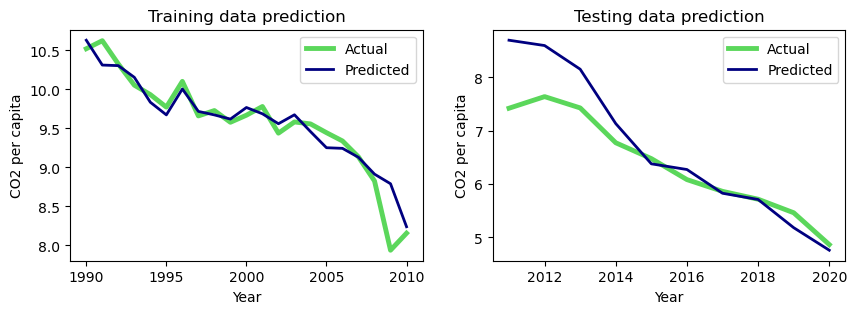

============= Features : ['SOL', 'SGAS', 'POLT', 'WINWAV', 'OIL'] =============


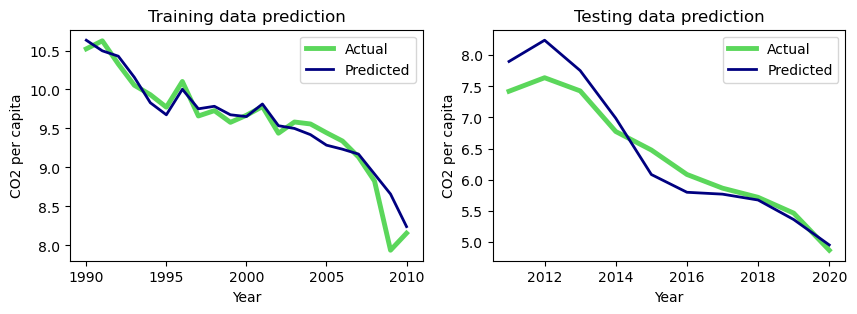

               MAE   MAPE   RMSE
16 Features  0.124  0.066  0.022
8 Features   0.050  0.025  0.005
5 Features   0.041  0.020  0.003


<Figure size 1000x400 with 0 Axes>

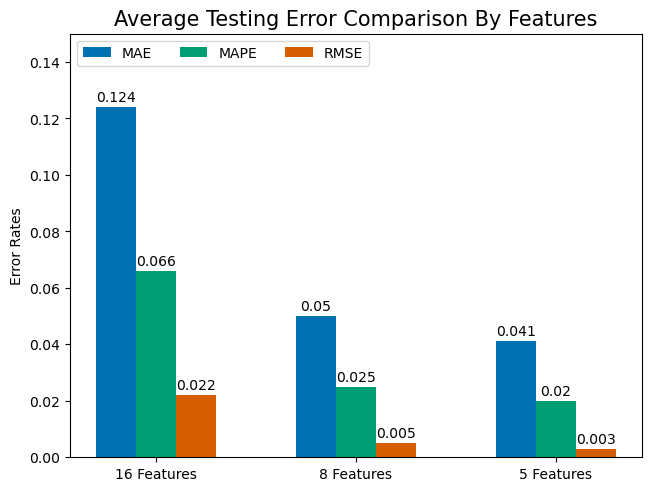

In [29]:
display_model_comparison(df_in=data_all)

# Estimate Future CO2 Emission
### Apply Pseudo data

In [30]:
# use pseudo data to make an estimation of future CO2
def estimate_future_co2():
    
   #  5 features  : wind & wave, solar, oil, sewage gas, poultry litter
    features = ['WINWAV','SOL','OIL', 'SGAS', 'POLT']
 
    # read data contains future estimation-moderate increase of features values for next 5 years
    data_read = pd.read_csv(PSEUDO_FILE)
    data_read.set_index('YR', inplace=True)
    
    data = data_read.copy()
    
    X_all = data.drop(['CO2'], axis=1)

    # apply the same process as earlier
    scaler = PowerTransformer()
    X_all[features] = scaler.fit_transform(X_all[features])
    y_all = data['CO2']
    y = y_all.iloc[:31]
    y = np.log(y)
    tss = TimeSeriesSplit(n_splits=2)
   
    # Support Vector Regressor : apply same model and process as earlier test/train
    model = SVR(kernel='poly', C=1.5, degree=3, gamma='auto', epsilon=1e-2) 
    X = X_all.iloc[:31]
    pseudo = X_all.iloc[31:]

    for train_index, test_index in tss.split(X):
        
        x_train, x_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # fit the model and make predictions         
        model.fit(x_train, y_train)
        y_test_pred = model.predict(x_train)
        
        # input pseudo data into model
        prediction_pre = model.predict(pseudo)
    
    # de-log the predicted value to convert
    prediction_cpt =  np.sign(prediction_pre) * np.exp(prediction_pre)
    
    yrs = np.arange(2021, 2026, 1, dtype=int)
    
    # total CO2 estimation  - multiply by population estimation 
    population_est = 67
    prediction_ttl = np.multiply(prediction_cpt, population_est)
    
    # dataframe for matplot
    result_df = pd.DataFrame({'CO2 per Capita': prediction_cpt, 
                              'CO2 Total':prediction_ttl }, index=yrs)
    print(result_df)
    
    # represent as graphs
    plt.style.use('default') 
    plt.figure(figsize=[10, 4])
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(1, 2, 1)
    
    plt.plot(yrs, prediction_cpt, color = 'navy', linewidth=3)
    plt.xlabel('Year')
    plt.ylabel('CO2 per capita (Metric Tons)')
    plt.title("Estimated CO2 per capita")
    
    plt.subplot(1, 2, 2)
    plt.plot(yrs, prediction_ttl, color = 'navy', linewidth=3)
    plt.xlabel('Year')
    plt.ylabel('CO2 Total (Million Metric Tons)')
    plt.title("Estimated Total CO2 ")
    plt.show()
      


      CO2 per Capita   CO2 Total
2021        5.260729  352.468837
2022        5.013676  335.916291
2023        4.775517  319.959640
2024        4.540779  304.232163
2025        4.306601  288.542277


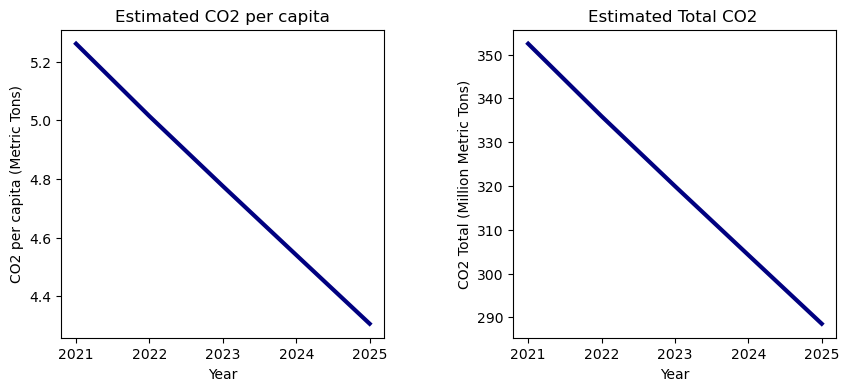

In [31]:
estimate_future_co2()

In [32]:
# end of the program. Thank you. #